## 1. Import/Install Dependencies

In [63]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.utils import env_checker
from gymnasium.spaces import Box, Discrete
from mss import mss
import cv2
import pydirectinput
import torch
from torch import nn

# Check version of pytorch
print(torch.__version__)
print(np.__version__)
print(cv2.__version__)

2.4.1+cu124
1.24.1
4.10.0


## 2. Construct Environment

In [54]:
class PacMan(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,50,80), dtype=np.uint8)
        self.action_space = Discrete(5)
        self.game_location = {'top':50, 'left':-2280, 'width':2000, 'height':1300}
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200}
        self.cap = mss()
        
    # Action method that is called to do something in the game
    def step(self, action):
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
            4: 'no_op'   # No operation (do nothing)
        }
        total_reward = 0
        if action != 4:
            pydirectinput.press(action_map[action])
        
        # Get the next observation
        new_observation = self.get_observation()
        # Determine if the game is finished   
        done = self.get_done()
        
        reward = 1
        if done:
            reward -= 10
        total_reward += reward
        
            
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return new_observation, total_reward, done, False, info
    
    def get_observation(self):
        # Get screen capture of game
        raw_screen_cap = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Convert to Grayscale
        gray_cap = cv2.cvtColor(raw_screen_cap, cv2.COLOR_BGR2GRAY)
        # Resize capture
        resized = cv2.resize(gray_cap, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel, raw_screen_cap, gray_cap
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Method to Restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pydirectinput.click(x=-890, y=374) # select game window
        pydirectinput.press('f1') # Start state 1 save
        return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
        
    def get_done(self):
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv2.cvtColor(lives_cap, cv2.COLOR_BGR2GRAY)
        # Load pacman life icon template for comparison
        pacman_life_template = cv2.imread('pacman_life_icon.png', 0)
        # Perform template matching using computer vision
        result = cv2.matchTemplate(lives_gray, pacman_life_template, cv2.TM_CCORR_NORMED)
        threshold = 0.8
        locations = np.where(result >= threshold)
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives == 0, lives_cap, lives_value

#### Demonstration

In [64]:
# declare environment
env = PacMan()

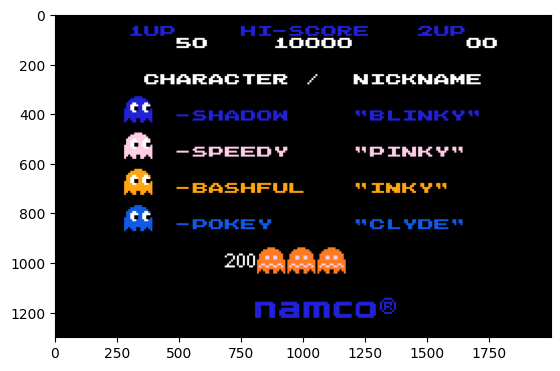

In [78]:
# check observation space
channel, raw_screen_cap, gray_cap = env.get_observation()
plt.imshow(raw_screen_cap)

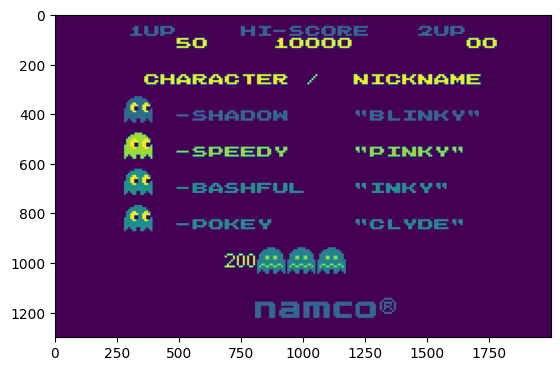

In [79]:
plt.imshow(gray_cap)

Game done?: True
Number of Lives left: 0


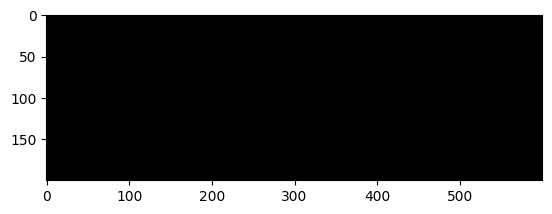

In [81]:
# check get_done method
done, lives_cap, lives_value= env.get_done()
print(f"Game done?: {done}") # is the game over?
print(f"Number of Lives left: {lives_value}") # how the pictures where interpreted to numbers
plt.imshow(lives_cap) # what the computer sees

In [ ]:
# how I determined the location of the observation space and the lives
import pydirectinput
import time

print("Move your mouse to the desired position and wait 5 seconds...")
time.sleep(5)
x, y = pydirectinput.position()
print(f"Mouse position: x={x}, y={y}")

In [82]:
# demonstration of rendering a screen to watch the model
env.render() # explain how this isn't necessary because I can already see it

In [83]:
# demonstration of closing the window
env.close()

In [85]:
# reset demo
env.reset()

((array([[[  0,   0, 111, ...,   0,   0,   0],
          [  0,   0, 111, ...,   0,   0,   0],
          [  0,   0, 111, ...,   0,   0,   0],
          ...,
          [  0,   0, 111, ...,   0,   0,   0],
          [  0,   0, 111, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8),
  array([[[242, 242, 242],
          [242, 242, 242],
          [242, 242, 242],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         [[242, 242, 242],
          [242, 242, 242],
          [242, 242, 242],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         [[242, 242, 242],
          [242, 242, 242],
          [242, 242, 242],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         ...,
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
    

#### Putting it together

In [86]:
# demo of the computer controlling the game
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = env.action_space.sample() # get an action
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
        

Total Reward for episode 0 is -9
Total Reward for episode 1 is -9
Total Reward for episode 2 is -9
Total Reward for episode 3 is -9
Total Reward for episode 4 is -9
Total Reward for episode 5 is -9
Total Reward for episode 6 is -9
Total Reward for episode 7 is -9
Total Reward for episode 8 is -9
Total Reward for episode 9 is -9


###

In [93]:
class PacMan(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,50,80), dtype=np.uint8)
        self.action_space = Discrete(5)
        self.game_location = {'top':50, 'left':-2280, 'width':2000, 'height':1300}
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200}
        self.cap = mss()
        
    # Action method that is called to do something in the game
    def step(self, action):
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
            4: 'no_op'   # No operation (do nothing)
        }
        total_reward = 0
        if action != 4:
            pydirectinput.press(action_map[action])
        
        # Get the next observation
        new_observation = self.get_observation()
        # Determine if the game is finished   
        done = self.get_done()
        
        reward = 1
        if done:
            reward -= 10
        total_reward += reward
        
            
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return new_observation, total_reward, done, False, info
    
    def get_observation(self):
        # Get screen capture of game
        raw_screen_cap = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Convert to Grayscale
        gray_cap = cv2.cvtColor(raw_screen_cap, cv2.COLOR_BGR2GRAY)
        # Resize capture
        resized = cv2.resize(gray_cap, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Method to Restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pydirectinput.click(x=-890, y=374) # select game window
        pydirectinput.press('f1') # Start state 1 save
        return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
        
    def get_done(self):
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv2.cvtColor(lives_cap, cv2.COLOR_BGR2GRAY)
        # Load pacman life icon template for comparison
        pacman_life_template = cv2.imread('pacman_life_icon.png', 0)
        # Perform template matching using computer vision
        result = cv2.matchTemplate(lives_gray, pacman_life_template, cv2.TM_CCORR_NORMED)
        threshold = 0.8
        locations = np.where(result >= threshold)
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives == 0

### Coding the Neural Network

In [94]:
# Designing convolutional neural network
class GameNet(nn.Module): # defines a new neural netwokr model that inherits from Pytorch's base class nn.module
    def __init__(self, input_channels, num_actions): 
        super(GameNet, self).__init__() # calls the initializer of the parent class nn.module 
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4) # convolutional layer with 32 filters, each of size 8 x8, applied with a stride of 4
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # convolutional layer with 64 filters, each of size 4 x 4, applied with a stride of 2
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # convolutional layer with 64 filters, each of size 3 x 3
        self.fc1 = nn.Linear(64 * 7 * 7, 512) # fully connected layer with 512 units
        self.fc2 = nn.Linear(512, num_actions) # final fully connected layer with output units equal to the number of possible actions
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Flatten the output from conv layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Define a replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [95]:
import random 
from torch.optim import Adam
from collections import namedtuple, deque # provides useful data structures may not need

# Hyperparameters
num_episodes = 5
batch_size = 32
gamma = 0.99
epsilon = 0.1 # Exploration rate
buffer_capacity = 10000
learning_rate = 1e-3    

# Initialize environment and model
env = PacMan()
input_channels = env.observation_space.shape[0]
num_actions = env.action_space.n

model = GameNet(input_channels, num_actions)
target_model = GameNet(input_channels, num_actions)
target_model.load_state_dict(model.state_dict())
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
replay_buffer = ReplayBuffer(buffer_capacity) # Stores experiences (state, action, reward, next state, done) for training

# Training function to choose an action using epsilon-greedy policy (Exploration vs exploitation)
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample() # Random action (Exploration)
    else:
        state = torch.FloatTensor(state).unsqueeze(0) # Add batch dimension
        with torch.no_grad():
            q_values = model(state)
        return q_values.argmax().item() # Action with highest Q-value

# Training function to procvide interaction with the environment, 
def train_gamenet(env, model, target_model, optimizer, criterion, replay_buffer, num_episodes=10):
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            action = select_action(state, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            
            # Store experience in replay buffer
            replay_buffer.push((state, action, reward, next_state, done))
            state = next_state
            
            # Perform optimization step
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)
                
                # Compute Q-values
                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_model(next_states).max(1)[0]
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))
                
                # Compute loss
                loss = criterion(q_values, target_q_values)
                
                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # Print progress
        print(f"Episode {episode}: Total Reward = {total_reward}, Loss: {loss}")
        
        # Update target network
        if episode % 100 == 0:
            target_model.load_state_dict(model.state_dict())
        
train_gamenet(env, model, target_model, optimizer, criterion, replay_buffer, num_episodes)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x768 and 3136x512)